# Model Assertion Framework - Monitor Model Drift and Decay using ML and statstical methods

### Table of contents
##### Part A: Introduction
##### Part B: EDA and Trading Strategy Error Metrics dataset
##### Part C: Model Assertion - Framework
    a. Single-Model Assertion
    b. Multiple-Model Assertion
##### Part D: Model Assertion - Framework Validation
    a. Define aggregated error metric calculations
    b. Retrain at Random
    c. Retrain using Model Assertion Framework
    d. Compare
##### Part E: Optimization model
##### Part G: Concluding


### Part A: Introduction

The three main objectives of this notebook is to 
    1) Introduce the capability of the Model Assertion Framework, 
    2) Valiate the competences of the Model Assertion Framework when monitor on-going/rolling ML strategy, 
    3) Proof 1) Our framework improve ML long-term by introducing retraining signals , and 2) Our optimization model can help identify the best parameter to achive highest prediction accuracy and lowest # of retrain time. 

1) The Capability of Model Assertion Framework:
    The model assertion framework takes in error metrics from any supervised regression model as an input. On a rolling basis, it constantly monitor the performance of different error metrics by using various ML and statistical methods by identify "small" peaks. When error metric value peaks, it usually indicate there could be signs of model decay or drift. Our goal is to identify those point and signal our user to retrain.
    
2) 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

#FeatureEngineering
#from talib import RSI, BBANDS, MACD, ATR, MA, MIDPRICE

#GetStrategy
import xgboost as xgb

#ValidateStrategy
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from sklearn.metrics import r2_score
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import DBSCAN
import hdbscan

from yfinance_data_func import *
from trading_strategy_sgb import *
from trading_strategy_validation import *
from model_assertion import *

### Part B: EDA and Trading Strategy Error Metrics dataset

In [2]:
yfin_data = pd.read_csv ("C://Users//Joshua Dai//Desktop//ModelAssertion//Data//yfinance_clean.csv", index_col=['Date'])
strat = Strategy_generation(yfin_data, '2016-01-01')
strat.train_XgbRegressor()
result = strat.run_XgbRegressor()
DF_SPY_result_Valid = ValidateStrategy.get_df(30,result)

In [3]:
DF_SPY_result_Valid

,Date,y_pred,y_test,MAE,MSE,MAPE,sMAPE
0,2016-01-04,199.086456,201.360001,2.273544,5.169004,0.011291,0.011355
1,2016-01-05,200.805084,198.820007,2.129311,4.554767,0.010638,0.010645
2,2016-01-06,200.952133,194.050003,3.720250,18.916311,0.018948,0.018746
3,2016-01-07,192.093231,191.919998,2.833496,14.194736,0.014437,0.014285
4,2016-01-08,193.258240,192.110001,2.496445,11.619479,0.012745,0.012620
...,...,...,...,...,...,...,...
1587,2022-04-22,207.386703,428.510010,237.154951,56346.842179,0.534028,0.728719
1588,2022-04-25,207.099884,416.100006,237.101586,56324.450345,0.533936,0.728555
1589,2022-04-26,207.042435,417.269989,236.785447,56188.529674,0.533545,0.727851
1590,2022-04-27,207.712952,427.809998,236.474310,56048.664873,0.533138,0.727107


### Part C: Model Assertion Framwork

#### a. Single-Model Assertion

1. Mean Std

Model:
* If a value is a certain number of standard deviations away from the mean, that data point is identified as an outlier. 
* The default value is 3.

Strength:
* The mdethod is very simple and easy to understand.
* The performance is not bad

Limitation:
* We should determine the number of standard deviations beforehand.

In [4]:
yf_data = yfin_data
validation = DF_SPY_result_Valid

start_date = '2016-01-01'
break_date = '2022-10-10' # placeholder

threshold = 3

break_time_std = pd.DataFrame(columns=['break_time'])
time_plot_std = pd.DataFrame(columns=['y_pred','y_test'])
error_metric_std = pd.DataFrame(columns=['Date','y_pred','y_test','MAE','MSE','MAPE','sMAPE'])

while break_date is not None:
    ''' define train test split using the 1) start_date and break_date'''
    strategy = Strategy_generation(yf_data, start_date)

    '''  run strategy and create error metrics'''
    strategy.train_XgbRegressor()
    result = strategy.run_XgbRegressor()
    validation = ValidateStrategy.get_df(30,result)

    ''' start model assertion framework to get the break time for the next run'''
    break_date = ModelAssertion(df_result = validation,window_me = 30).outlier_mean_std(window_out_train = 100,window_out_test = 30, std_num = threshold)

    if break_date is not None:
      '''add break time df '''
      break_time_std = break_time_std.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_std = error_metric_std.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_std = time_plot_std.append(temp_time_plot)
      start_date = break_date
    # else:
    #   break

2016-08-23
2017-03-01
2017-09-05
2018-09-11
2019-08-16
2020-02-24
2020-12-29
2021-08-25


In [5]:
print("model signals retrain signals ", len(break_time_std), "times between 2016-01-01 to 2022-05-01")

model signals retrain signals  8 times between 2016-01-01 to 2022-05-01


<AxesSubplot:>

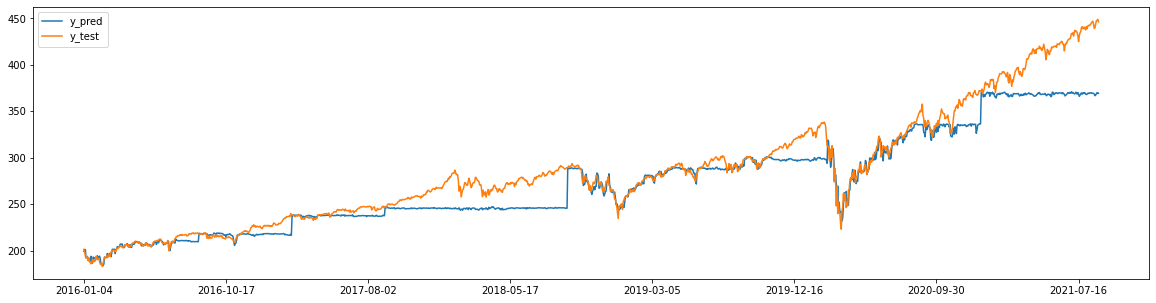

In [6]:
time_plot_std.plot(figsize=(20, 5))

2. Isolation Forest

Model:
* Isolation Forest is an Unsupervised Learning technique using Binary Decision Trees bagging to detect outlier/anomaly
* The principle is that outliers are less frequent than regular observations and are different from them in terms of values,so it was easier for the tree to separate them from other observations which means they have very short path in the trees. 

Strength:
* Isolation Forests are computationally efficient and have been proven to be very effective in Anomaly detection.

Limitation:
* The final anomaly score depends on the contamination parameter, provided while training the model. This implies that we should have an idea of what percentage of the data is anomalous beforehand to get a better prediction.

Reference:
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e 
* https://www.analyticsvidhya.com/blog/2021/07/anomaly-detection-using-isolation-forest-a-complete-guide/ 
* https://towardsdatascience.com/isolation-forest-from-scratch-e7e5978e6f4c

In [7]:
yf_data = yfin_data
validation = DF_SPY_result_Valid

start_date = '2016-01-01'
break_date = '2022-10-10' # placeholder

break_time_iso = pd.DataFrame(columns=['break_time'])
time_plot_iso = pd.DataFrame(columns=['y_pred','y_test'])
error_metric_iso = pd.DataFrame(columns=['Date','y_pred','y_test','MAE','MSE','MAPE','sMAPE'])

while break_date is not None:
    ''' define train test split using the 1) start_date and break_date'''
    strategy = Strategy_generation(yf_data, start_date)

    '''  run strategy and create error metrics'''
    strategy.train_XgbRegressor()
    result = strategy.run_XgbRegressor()
    validation = ValidateStrategy.get_df(30,result)

    ''' start model assertion framework to get the break time for the next run'''
    break_date = ModelAssertion(df_result = validation,window_me = 30).outlier_iso_forest(window_out_train =100,window_out_test = 30)

    if break_date is not None:
      '''add break time df '''
      break_time_iso = break_time_iso.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_iso = error_metric_iso.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_iso = time_plot_iso.append(temp_time_plot)
      start_date = break_date
    # else:
    #   break

2016-07-12
2017-01-17
2017-07-24
2018-01-29
2018-08-06
2019-02-15
2019-08-22
2020-02-28
2020-09-03
2021-03-12
2021-09-16
2022-03-24


In [8]:
print("model signals retrain signals ", len(break_time_iso), "times between 2016-01-01 to 2022-05-01")

model signals retrain signals  12 times between 2016-01-01 to 2022-05-01


<AxesSubplot:>

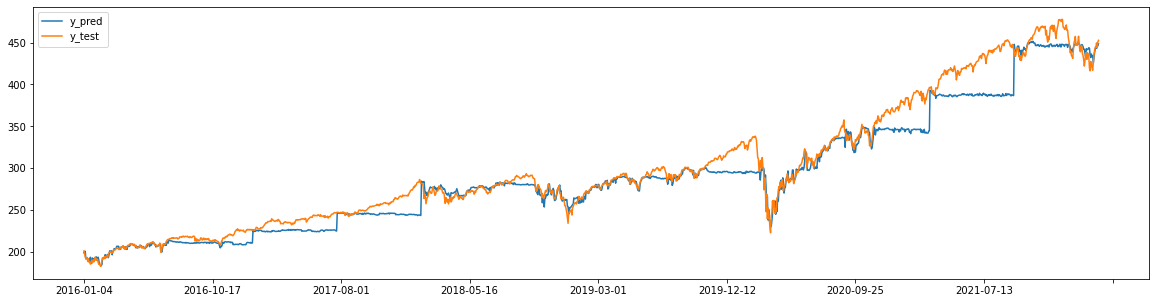

In [9]:
time_plot_iso.plot(figsize=(20, 5))

3. DBSCAN

Model:
* DBSCAN groups ‘densely grouped’ data points into a single cluster. 

Advantages:

* Does not require a-priori specification of number of clusters.

* Able to identify noise data while clustering.

* DBSCAN algorithm is able to find arbitrarily size and arbitrarily shaped clusters.

Disadvantages:

* DBSCAN algorithm fails in case of varying density clusters.

* Choosing a meaningful eps value can be difficult if the data isn't well understood.

Reference:
* https://medium.com/@dilip.voleti/dbscan-algorithm-for-fraud-detection-outlier-detection-in-a-data-set-60a10ad06ea8

In [10]:
yf_data = yfin_data
validation = DF_SPY_result_Valid

start_date = '2016-01-01'
break_date = '2022-10-10' # placeholder


break_time_dbscan = pd.DataFrame(columns=['break_time'])
time_plot_dbscan = pd.DataFrame(columns=['y_pred','y_test'])
error_metric_dbscan = pd.DataFrame(columns=['Date','y_pred','y_test','MAE','MSE','MAPE','sMAPE'])

while break_date is not None:
    ''' define train test split using the 1) start_date and break_date'''
    strategy = Strategy_generation(yf_data, start_date)

    '''  run strategy and create error metrics'''
    strategy.train_XgbRegressor()
    result = strategy.run_XgbRegressor()
    validation = ValidateStrategy.get_df(30,result)

    ''' start model assertion framework to get the break time for the next run'''
    break_date = ModelAssertion(df_result = validation,window_me = 30).outlier_dbscan(window_out_train =100,window_out_test = 30, DF_SPY_result_Valid=DF_SPY_result_Valid)

    if break_date is not None:
      '''add break time df '''
      break_time_dbscan = break_time_dbscan.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_dbscan = error_metric_dbscan.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_dbscan = time_plot_dbscan.append(temp_time_plot)
      start_date = break_date
    # else:
    #   break

2016-09-15
2017-05-31
2018-02-12
2018-10-24
2019-07-11
2020-03-24
2020-12-03
2021-08-18


In [11]:
print("model signals retrain signals ", len(break_time_dbscan), "times between 2016-01-01 to 2022-05-01")

model signals retrain signals  8 times between 2016-01-01 to 2022-05-01


<AxesSubplot:>

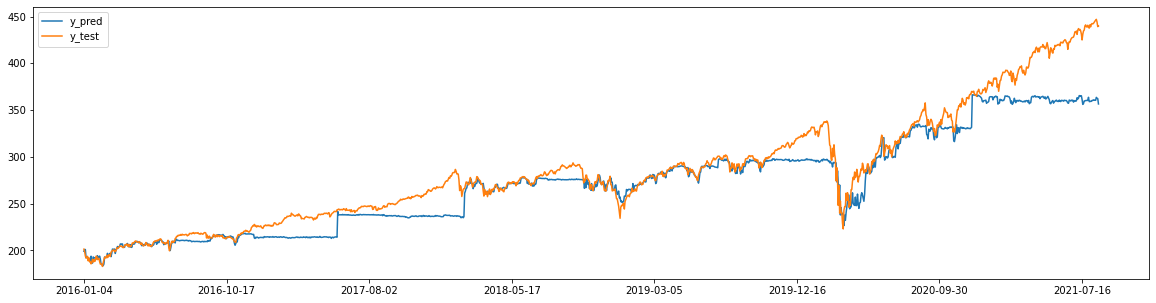

In [12]:
time_plot_dbscan.plot(figsize=(20, 5))

4. HDBSCAN

Model:
* It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

Advantages:
* HDBSCAN inherited all the benefits of DBSCAN and removed the varying density clusters issue.
* HDBSCAN is stable over runs and subsampling, and has good stability over parameter choices.

Disadvantages:
* It may have some problems of noise detection if we cannot control the density threshold.

In [13]:
yf_data = yfin_data
validation = DF_SPY_result_Valid

start_date = '2016-01-01'
break_date = '2022-10-10' # placeholder

break_time_hdbscan = pd.DataFrame(columns=['break_time'])
time_plot_hdbscan = pd.DataFrame(columns=['y_pred','y_test'])
error_metric_hdbscan = pd.DataFrame(columns=['Date','y_pred','y_test','MAE','MSE','MAPE','sMAPE'])

while break_date is not None:
    ''' define train test split using the 1) start_date and break_date'''
    strategy = Strategy_generation(yf_data, start_date)

    '''  run strategy and create error metrics'''
    strategy.train_XgbRegressor()
    result = strategy.run_XgbRegressor()
    validation = ValidateStrategy.get_df(30,result)

    ''' start model assertion framework to get the break time for the next run'''
    break_date = ModelAssertion(df_result = validation,window_me = 30).outlier_hdbscan(window_out_train =100,window_out_test = 30, DF_SPY_result_Valid=DF_SPY_result_Valid)

    if break_date is not None:
      '''add break time df '''
      break_time_hdbscan = break_time_hdbscan.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_hdbscan = error_metric_hdbscan.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_hdbscan = time_plot_hdbscan.append(temp_time_plot)
      start_date = break_date
    # else:
    #   break

2016-08-29
2017-04-26
2017-12-19
2018-08-16
2019-04-15
2019-12-09
2020-08-05
2021-04-01
2021-11-24


In [14]:
print("model signals retrain signals ", len(break_time_hdbscan), "times between 2016-01-01 to 2022-05-01")

model signals retrain signals  9 times between 2016-01-01 to 2022-05-01


<AxesSubplot:>

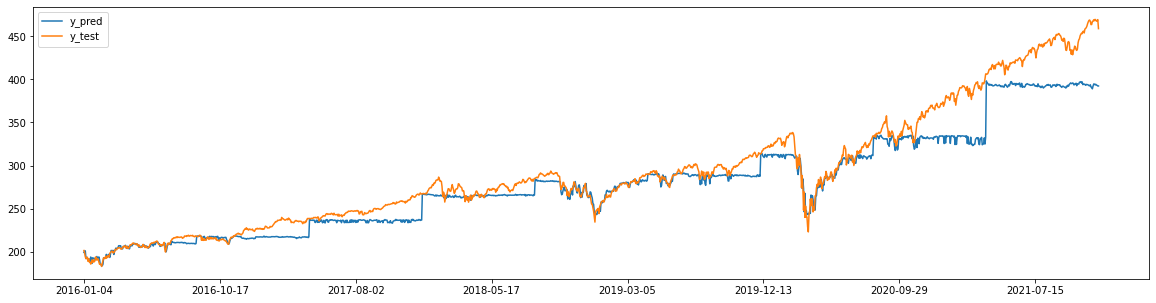

In [15]:
time_plot_hdbscan.plot(figsize=(20, 5))

#### b. Multiple-Model Assertion

In [16]:
break_time_all = pd.DataFrame(columns=['break_time'])
time_plot_all = pd.DataFrame(columns=['y_pred','y_test'])
error_metric_all = pd.DataFrame(columns=['Date',	'y_pred',	'y_test',	'MAE',	'MSE',	'MAPE',	'sMAPE'])
yf_data = yfin_data
start_date = '2016-01-01'

for i in range(20):
  ''' define train test split using the 1) start_date and break_date'''
  strategy = Strategy_generation(yf_data, start_date)

  '''  run strategy and create error metrics'''
  strategy.train_XgbRegressor()
  result = strategy.run_XgbRegressor()
  validation = ValidateStrategy.get_df(30,result)

  ''' start model assertion framework to get the break time for the next run'''
  std_break = ModelAssertion(df_result = validation,window_me = 30).outlier_mean_std(window_out_train =100,window_out_test = 30, std_num = 3)
  iso_break = ModelAssertion(df_result = validation,window_me = 30).outlier_iso_forest(window_out_train =100,window_out_test = 30)
  dbscan_break = ModelAssertion(df_result = validation,window_me = 30).outlier_dbscan(window_out_train =100,window_out_test = 30, DF_SPY_result_Valid=DF_SPY_result_Valid)
  hdbscan_break = ModelAssertion(df_result = validation,window_me = 30).outlier_hdbscan(window_out_train =100,window_out_test = 30, DF_SPY_result_Valid=DF_SPY_result_Valid)
  date_list = [std_break,iso_break,dbscan_break,hdbscan_break]
  date_list = list(filter(lambda item: item is not None, date_list))
  if len(date_list) == 0 :
        break     
  break_date = min(date_list)

  if break_date is not None:
      '''add break time df '''
      break_time_all = break_time_all.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_all = error_metric_all.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_all = time_plot_all.append(temp_time_plot)
      start_date = break_date

2016-08-23
2016-07-12
2016-09-15
2016-08-29
2017-01-17
2017-01-17
2017-03-24
2017-03-08
2017-09-21
2017-07-24
2017-09-28
2017-09-12
2018-01-29
2018-01-29
2018-04-06
2018-03-20
2019-08-05
2018-08-06
2018-10-10
2018-09-24
2019-08-09
2019-02-15
2019-04-22
2019-04-03
2019-08-22
2019-08-22
2019-10-29
2019-10-11
2020-03-02
2020-02-28
2020-05-06
2020-04-20
2021-01-07
2020-09-03
2020-11-09
2020-10-22
2021-03-12
2021-03-12
2021-05-19
2021-05-03
2021-12-09
2021-09-16
2021-11-22
2021-11-04
2022-03-24


In [17]:
print("model signals retrain signals ", len(break_time_all), "times between 2016-01-01 to 2022-05-01")

model signals retrain signals  12 times between 2016-01-01 to 2022-05-01


In [18]:
time_plot_all

,y_pred,y_test
2016-01-04,199.086456,201.360001
2016-01-05,200.805084,198.820007
2016-01-06,200.952133,194.050003
2016-01-07,192.093231,191.919998
2016-01-08,193.258240,192.110001
...,...,...
2022-03-18,443.605194,444.390015
2022-03-21,443.118011,449.589996
2022-03-22,446.847992,443.799988
2022-03-23,446.140991,450.489990


<AxesSubplot:>

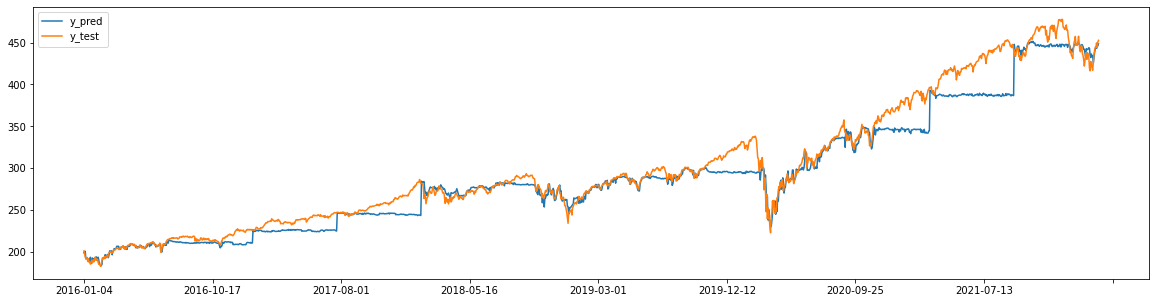

In [19]:
time_plot_all.plot(figsize=(20, 5))

### Part D: Model Assertion - Framework Validation

#### a. Define aggregated error metric calculations

In [28]:
agg_error_metrics = pd.DataFrame(columns=['agg_test_diff',	'agg_MAE',	'agg_MSE',	'agg_MAPE',	'agg_sMAPE'])
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_all['y_pred'])-sum(error_metric_all['y_test'])),
                                              'agg_MAE':sum(error_metric_all['MAE']),	
                                              'agg_MSE':sum(error_metric_all['MSE']),	
                                              'agg_MAPE':sum(error_metric_all['MAPE']),
                                              'agg_sMAPE':sum(error_metric_all['sMAPE'])}, index=['all'])
agg_error_metrics = agg_error_metrics.append(val)
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_std['y_pred'])-sum(error_metric_std['y_test'])),
                                              'agg_MAE':sum(error_metric_std['MAE']),	
                                              'agg_MSE':sum(error_metric_std['MSE']),	
                                              'agg_MAPE':sum(error_metric_std['MAPE']),
                                              'agg_sMAPE':sum(error_metric_std['sMAPE'])}, index=['std'])
agg_error_metrics = agg_error_metrics.append(val)
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_iso['y_pred'])-sum(error_metric_iso['y_test'])),
                                              'agg_MAE':sum(error_metric_iso['MAE']),	
                                              'agg_MSE':sum(error_metric_iso['MSE']),	
                                              'agg_MAPE':sum(error_metric_iso['MAPE']),
                                              'agg_sMAPE':sum(error_metric_iso['sMAPE'])}, index=['iso'])
agg_error_metrics = agg_error_metrics.append(val)
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_dbscan['y_pred'])-sum(error_metric_dbscan['y_test'])),
                                              'agg_MAE':sum(error_metric_dbscan['MAE']),	
                                              'agg_MSE':sum(error_metric_dbscan['MSE']),	
                                              'agg_MAPE':sum(error_metric_dbscan['MAPE']),
                                              'agg_sMAPE':sum(error_metric_dbscan['sMAPE'])}, index=['dbscan'])
agg_error_metrics = agg_error_metrics.append(val)
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_hdbscan['y_pred'])-sum(error_metric_hdbscan['y_test'])),
                                              'agg_MAE':sum(error_metric_hdbscan['MAE']),	
                                              'agg_MSE':sum(error_metric_hdbscan['MSE']),	
                                              'agg_MAPE':sum(error_metric_hdbscan['MAPE']),
                                              'agg_sMAPE':sum(error_metric_hdbscan['sMAPE'])}, index=['hdbscan'])
agg_error_metrics = agg_error_metrics.append(val)

In [29]:
agg_error_metrics

,agg_test_diff,agg_MAE,agg_MSE,agg_MAPE,agg_sMAPE
all,15411.812408,16054.792460,383045.280358,49.598449,50.970298
std,18309.749695,17338.667317,525718.394620,55.278818,57.546555
iso,15411.812408,16054.792460,383045.280358,49.598449,50.970298
dbscan,18892.285034,17926.093782,574261.498621,57.616574,60.104490
hdbscan,20446.416565,18933.417411,569528.907247,57.414588,59.529082


#### b. Retrain at Random

In [30]:
break_date_list = ['2016-07-01','2017-02-01',
                   '2017-08-01', '2018-03-01', '2018-09-01', 
                   '2019-04-01', '2019-10-01', '2020-05-01', 
                   '2010-11-01','2021-06-01','2021-12-01', '2022-03-01']

In [45]:
yf_data = yfin_data
validation = DF_SPY_result_Valid

start_date = '2016-01-01'
break_date_list = ['2016-07-01','2017-02-01',
                   '2017-08-01', '2018-03-01', '2018-09-01', 
                   '2019-04-01', '2019-10-01', '2020-05-01', 
                   '2020-11-01','2021-06-01','2021-12-01', '2022-03-01']
i=-1

break_time_random = pd.DataFrame(columns=['break_time'])
time_plot_random = pd.DataFrame(columns=['y_pred','y_test'])
error_metric_random = pd.DataFrame(columns=['Date','y_pred','y_test','MAE','MSE','MAPE','sMAPE'])

for i in range(11):
    ''' define train test split using the 1) start_date and break_date'''
    strategy = Strategy_generation(yf_data, start_date)
    i+=1
    print(2)

    '''  run strategy and create error metrics'''
    strategy.train_XgbRegressor()
    result = strategy.run_XgbRegressor()
    validation = ValidateStrategy.get_df(30,result)

    ''' start model assertion framework to get the break time for the next run'''
    break_date = break_date_list[i]
    print(1)
    if break_date is not None:
      '''add break time df '''
      break_time_random = break_time_random.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_random = error_metric_random.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_random = time_plot_random.append(temp_time_plot)
      start_date = break_date
    # else:
    #   break

2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1
2
1


In [46]:
print("model signals retrain signals ", len(break_time_all), "times between 2016-01-01 to 2022-05-01")

model signals retrain signals  12 times between 2016-01-01 to 2022-05-01


<AxesSubplot:>

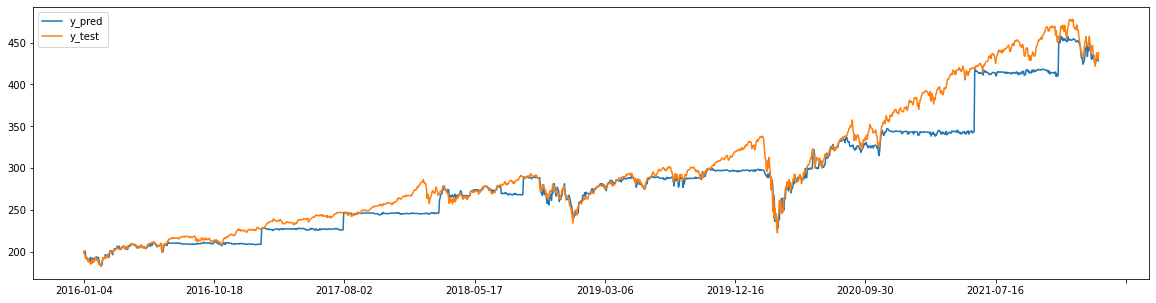

In [47]:
time_plot_random.plot(figsize=(20, 5))

#### c. Compare with Retrain using Model Assertion Framework

In [48]:
agg_error_metrics = pd.DataFrame(columns=['agg_test_diff',	'agg_MAE',	'agg_MSE',	'agg_MAPE',	'agg_sMAPE'])
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_all['y_pred'])-sum(error_metric_all['y_test'])),
                                              'agg_MAE':sum(error_metric_all['MAE']),	
                                              'agg_MSE':sum(error_metric_all['MSE']),	
                                              'agg_MAPE':sum(error_metric_all['MAPE']),
                                              'agg_sMAPE':sum(error_metric_all['sMAPE'])}, index=['Model_assertion_breaktime'])
agg_error_metrics = agg_error_metrics.append(val)
val = pd.DataFrame({'agg_test_diff':abs(sum(error_metric_random['y_pred'])-sum(error_metric_random['y_test'])),
                                              'agg_MAE':sum(error_metric_random['MAE']),	
                                              'agg_MSE':sum(error_metric_random['MSE']),	
                                              'agg_MAPE':sum(error_metric_random['MAPE']),
                                              'agg_sMAPE':sum(error_metric_random['sMAPE'])}, index=['random_break_time'])
agg_error_metrics = agg_error_metrics.append(val)

In [49]:
agg_error_metrics

,agg_test_diff,agg_MAE,agg_MSE,agg_MAPE,agg_sMAPE
Model_assertion_breaktime,15411.812408,16054.792460,383045.280358,49.598449,50.970298
random_break_time,19689.171555,18607.090208,533208.183096,56.802024,58.891003


### Part E: Optimization model

In [52]:
# threshold = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
threshold = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
optimization_df = pd.DataFrame(columns=['threshold',	'retrain_count',	'agg_MAE'])
j = -1
for i in range(len(threshold)):
  break_time_std = pd.DataFrame(columns=['break_time'])
  time_plot_std = pd.DataFrame(columns=['y_pred','y_test'])
  error_metric_std = pd.DataFrame(columns=['Date',	'y_pred',	'y_test',	'MAE',	'MSE',	'MAPE',	'sMAPE'])
  yf_data = yfin_data
  start_date = '2016-01-01'
  break_date = '2022-10-10' # placeholder
  j += 1
  print(1)
  while break_date is not None:
    ''' define train test split using the 1) start_date and break_date'''
    strategy = Strategy_generation(yf_data, start_date)

    '''  run strategy and create error metrics'''
    strategy.train_XgbRegressor()
    result = strategy.run_XgbRegressor()
    validation = ValidateStrategy.get_df(30,result)

    ''' start model assertion framework to get the break time for the next run'''
    break_date = ModelAssertion(df_result = validation,window_me = 30).outlier_mean_std(window_out_train =100,window_out_test = 30, std_num = threshold[j])
    print(2)

    if break_date is not None:
      '''add break time df '''
      break_time_std = break_time_std.append({'break_time':break_date}, ignore_index=True)

      ''' create error metric df'''
      error_metric_val = validation.loc[validation["Date"].between(start_date, break_date)]
      error_metric_std = error_metric_std.append(error_metric_val)

      ''' y_pred vs actual for time plot '''
      temp_time_plot = result.loc[start_date : break_date]
      time_plot_std = time_plot_std.append(temp_time_plot)
      start_date = break_date
    # else:
    #   break
  print(3)
  opt_val = pd.DataFrame({'threshold': threshold[i],	
                      'retrain_count':len(break_time_std),	
                      'agg_MAE':sum(error_metric_std['MAE'])}, index=[i])
  optimization_df = optimization_df.append(opt_val, ignore_index=True)
    

1
2016-08-01
2
2017-02-06
2
2017-08-11
2
2018-02-16
2
2018-08-23
2
2019-07-18
2
2020-01-23
2
2020-10-01
2
2021-04-09
2
2021-10-13
2
2
3
1
2016-08-04
2
2017-02-09
2
2017-08-16
2
2018-02-22
2
2018-08-28
2
2019-03-07
2
2019-09-11
2
2020-03-18
2
2020-12-11
2
2021-06-21
2
2021-12-23
2
2
3
1
2016-08-09
2
2017-02-14
2
2017-08-21
2
2018-02-27
2
2018-08-31
2
2019-08-07
2
2020-02-12
2
2020-12-14
2
2021-06-22
2
2021-12-27
2
2
3
1
2016-08-12
2
2017-02-17
2
2017-08-24
2
2018-03-02
2
2018-09-06
2
2019-07-31
2
2020-02-05
2
2020-10-09
2
2021-04-19
2
2021-10-21
2
2
3
1
2016-08-17
2
2017-02-23
2
2017-08-29
2
2018-03-07
2
2018-09-11
2
2019-08-07
2
2020-02-12
2
2020-12-23
2
2021-07-01
2
2022-01-05
2
2
3
1
2016-08-19
2
2017-02-27
2
2017-08-31
2
2018-08-03
2
2019-08-01
2
2020-02-06
2
2020-12-11
2
2021-06-23
2
2021-12-28
2
2
3
1
2016-08-23
2
2017-03-01
2
2017-09-05
2
2018-09-11
2
2019-08-16
2
2020-02-24
2
2020-12-29
2
2021-08-25
2
2
3
1
2016-08-25
2
2017-03-03
2
2017-10-05
2
2019-08-15
2
2020-02-21
2
2021-01

In [55]:
opt_model_df = optimization_df
opt_model_df

,threshold,retrain_count,agg_MAE
0,0.1,10,13959.177928
1,0.5,11,16775.685409
2,1.0,10,15487.985006
3,1.5,10,13172.133854
4,2.0,10,14949.320390
5,2.5,9,18806.180815
6,3.0,8,17338.667317
7,3.5,7,24890.327192


In [58]:
optimization_df_sorted

,threshold,retrain_count,agg_MAE
7,3.5,7,24890.327192
6,3.0,8,17338.667317
5,2.5,9,18806.180815
4,2.0,10,14949.320390
3,1.5,10,13172.133854
2,1.0,10,15487.985006
1,0.5,11,16775.685409
0,0.1,10,13959.177928


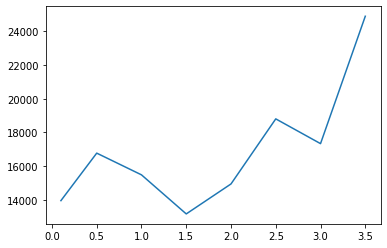

In [57]:
optimization_df_sorted = opt_model_df.sort_values(by='threshold', ascending=False)
plt.plot(optimization_df_sorted['threshold'], optimization_df_sorted['agg_MAE'])

### Part D: Conclusion